# Solución de raspado web

## Paso 1: Instalar dependencias

In [10]:
pip install pandas requests lxml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Paso 2: Descargar HTML

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import io

# Obtener el HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)
# Verificamos la respuesta
print("Estado:", response.status_code)

Estado: 200
Se encontraron 27 tablas.


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,4.765,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.282,6 January 2017,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.845,8 November 2018,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.810,21 September 2016,[5]
4,5,"""As It Was""",Harry Styles,3.809,1 April 2022,[6]


## Paso 3: Transformar el HTML

In [15]:
# Extraer la tabla con pandas
html = io.StringIO(response.text)
tables = pd.read_html(html)
print(f"Se encontraron {len(tables)} tablas.")

Se encontraron 27 tablas.


In [17]:
# Inspeccionamos las primeras filas de la tabla correcta
df = tables[0]
df.head()  # Muestra las primeras 5 filas

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,4.765,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.282,6 January 2017,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.845,8 November 2018,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.810,21 September 2016,[5]
4,5,"""As It Was""",Harry Styles,3.809,1 April 2022,[6]


## Paso 4: Procesar el marco de datos

In [18]:
# Limpieza de datos

# Renombramos columnas si es necesario
df.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released"]

# Eliminamos notas entre corchetes
df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True)
df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True)

# Convertimos Streams a números flotantes
df["Streams (billions)"] = df["Streams (billions)"].astype(float)

# Convertimos fechas a datetime
df["Date released"] = pd.to_datetime(df["Date released"], errors="coerce")

df.info()

ValueError: Length mismatch: Expected axis has 6 elements, new values have 5 elements

## Paso 5: almacenar los datos en sqlite

In [7]:
# Conectar a SQLite y guardar los datos
conn = sqlite3.connect("tesla_revenues.db")
cursor = conn.cursor()

In [8]:
# Crear tabla en SQLite
cursor.execute("""
CREATE TABLE IF NOT EXISTS ingresos (
    fecha TEXT,
    ingresos REAL
)
""")

In [9]:
# Insertar datos en la base de datos
for index, row in df.iterrows():
    cursor.execute("INSERT INTO ingresos (fecha, ingresos) VALUES (?, ?)", (row["Fecha"], row["Ingresos"]))

conn.commit()
conn.close()

## Paso 6: Visualiza los datos

### Visualización de series de tiempo

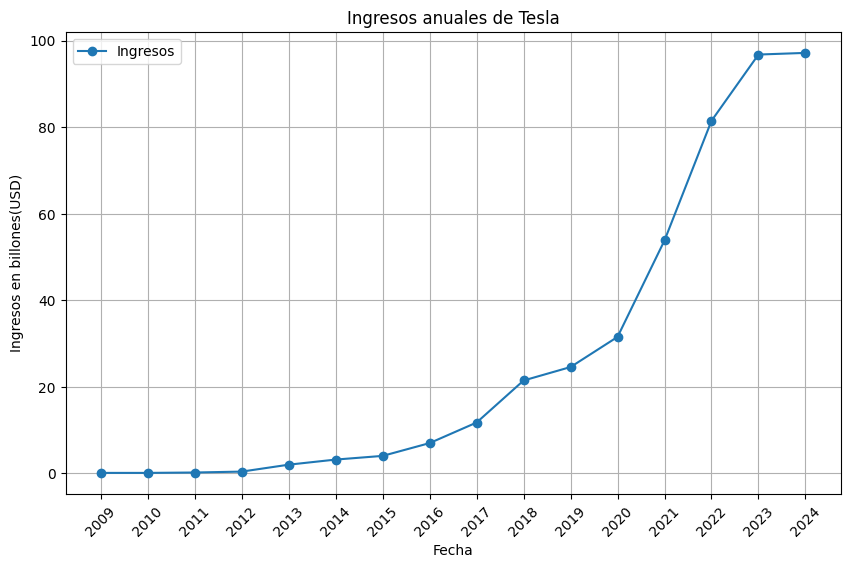

In [10]:
# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(df["Fecha"], df["Ingresos"], marker='o', label="Ingresos")
plt.title("Ingresos anuales de Tesla")
plt.xlabel("Fecha")
plt.ylabel("Ingresos en billones(USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Guardar y mostrar el gráfico
plt.savefig("revenue_plot.png")
plt.show()


## Extra 

Con las librerías utilizadas anteriormente extrae las ganancias del último año de Tesla desde la siguiente URL https://companies-market-cap-copy.vercel.app/earnings.html

Nota: En esta ocasión, hemos optado por escribir todo el código como un único bloque.  Así es como se vería en un archivo de Python en lugar de un Notebook de Jupyter.

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL objetivo
url = "https://companies-market-cap-copy.vercel.app/earnings.html"

# Hacer la solicitud a la página
response = requests.get(url)
response.raise_for_status() 

# Analizar el contenido HTML
html = BeautifulSoup(response.text, "html.parser")

#Extraer la tabla de ganancias anuales
table = html.find("table", {"class": "table"}) 
rows = table.find_all("tr")[1:] 

# Extraer datos y convertirlos en listas
data = []
for row in rows:
    columns = row.find_all("td")
    year = columns[0].text.strip() 
    earnings = columns[1].text.strip()  
    data.append({"Año": year, "Ganancias": earnings})

# Crear un DataFrame con los datos
df = pd.DataFrame(data)

# Convertir ganancias a valores numéricos
def parse_earnings(value):
    try:
        value = value.replace(",", "").replace("$", "").strip()
        if "Billion" in value: 
            return float(value.replace("Billion", "")) * 1_000_000_000
        elif "Million" in value:
            return float(value.replace("Million", "")) * 1_000_000_000
        elif "M" in value:  
            return float(value.replace("M", "")) * 1_000_000
        elif "B" in value:
            return float(value.replace("B", "")) * 1_000_000_000
        else:
            return float(value)
    except ValueError:
        print(f"Advertencia: No se pudo convertir el valor '{value}'. Estableciendo como NaN.")
        return float("nan") 

# Limpiar la columna "Año"
def clean_year(value):
    try:
        return int(value.split()[0]) 
    except ValueError:
        print(f"Advertencia: No se pudo procesar el valor del año '{value}'. Estableciendo como NaN.")
        return float("nan")  

df["Ganancias"] = df["Ganancias"].apply(parse_earnings)
df["Año"] = df["Año"].apply(clean_year)

df = df.sort_values("Año", ascending=False)

# Obtener la fila del año más reciente y sus ganancias
ultimo_ano_fila = df.iloc[0]  

# Extraer el año específico de esa fila
ultimo_ano = int(ultimo_ano_fila["Año"])

mensaje = f"Tesla ha generado ${ultimo_ano_fila['Ganancias']:,.2f} de ganancias en el año {ultimo_ano}."

# Mostrar el resultado
print(mensaje)

Tesla ha generado $8,730,000,000.00 de ganancias en el año 2024.
